# CISC-839 Data Analytics Project

## A Session Based - Recommendation System

This System is a session-based recommendation system, powered by the Ternec dataset. Leveraging the [Tenrec: A Large-scale Multipurpose Benchmark Dataset for Recommender Systems](https://proceedings.neurips.cc/paper_files/paper/2022/file/4ad4fc1528374422dd7a69dea9e72948-Paper-Datasets_and_Benchmarks.pdf) Paper, we aim to deliver personalized recommendations that adapt to users' session-specific preferences in real-time. Join us as we revolutionize the way users discover content by harnessing the power of session-based modeling and the rich insights provided by the Ternec dataset.

---

## Team Members
- Adham Mokhtar
- Manar El-Ghobashy
- Yara Hassan
- Yara El-Zahy

---

## Some Explanations

A recommendation system is like having a smart computer friend that suggests things you might like based on the things you already enjoy. It helps you discover new things that you'll love!


There are three main types of recommendation systems:
1. Content-Based: It recommends things based on the features of what you already like. For example, if you enjoy action movies, it will suggest more action movies.
2. Collaborative Filtering: It recommends things based on what other people with similar tastes enjoy. If someone similar to you likes a certain video game, it will suggest that game to you.
3. Hybrid: This combines different methods to give you even better recommendations. It uses both the features of what you like and what other people like to suggest things you'll enjoy.

"Session-based" and "cold start" are specific challenges or scenarios that can occur in recommendation systems:
- Session-based Recommendations: This means giving recommendations based on what you're doing right now. For example, if you're browsing a website, it suggests things related to what you're looking at.
- Cold Start Problem: This happens when the system doesn't know much about a new user or item. It's like when you join a new website or they add new things. The system has to find other ways to give you recommendations since it doesn't have much information yet.

In this notebook (project) we will use collaborative filtering to try solving the session-based challenge.

For session-based recommendations, a type of recommendation system called "Sequential Recommendation" is more suitable.

- Sequential Recommendation systems are specifically designed to make recommendations based on a user's current session or sequence of actions within a single browsing session. These systems analyze the order and context of the user's interactions to understand their immediate preferences and provide relevant suggestions.
- In a session-based recommendation system, the focus is on capturing the user's current interests and recommending items that align with those interests. This type of system takes into account the sequence of actions, such as clicks, views, or purchases, during a session to make accurate and timely recommendations.

---

In this notebook, we will explore and analyze the performance of our best session-based recommendation model. We selected the NextItNet model as it outperformed other candidate models, including GRU4Rec, BERT4Rec, and SASRec, based on the NDCG@20 evaluation metric. Our comparison was conducted on two distinct datasets: one containing users with age 3 and the other with users having age 0.

The evaluation results for each model on both user groups are as follows:
| Model | NDCG@20 for users with age 3 | NDCG@20 for users with age 0 |
| --- | --- | ---|
| NextItNet| 0.0112 | 0.0086 |
| SASRec | 0.0103 | 0.0079 |
| GRU4Rec | 0.0100 | 0.0058 |
| BERTModel | 7.7849e-05 | 1.1388e-05 |

From the comparison, it is evident that the NextItNet model consistently outperformed the other models on both user groups, showcasing its ability to capture sequential patterns effectively for session-based recommendation tasks.

We will delve into a detailed discussion of the NextItNet model's performance on both users' groups together, focusing on its strengths and limitations. Additionally, we will assess the model's ability to generalize across different datasets, as it was trained and evaluated on two distinct age groups.

To validate the model's generalization, we will further test its performance on a separate test dataset, combining interactions from both age groups. This will provide insights into how well the NextItNet model adapts to unseen data, showcasing its robustness and transferability.

Through our analysis, we aim to gain a comprehensive understanding of the NextItNet model's capabilities and uncover any potential challenges it might encounter in real-world scenarios. By comprehensively evaluating the model's performance and generalization abilities, we can make informed decisions about its applicability in various recommendation systems.

---

## Recommended Pipline
- Data Preprocessing
- Session Representation
- Train-Test-Validation Split
- Model Selection
    - Model Training
    - Model Evaluation
    - Hyperparameter Tuning
    - Performance Analysis

---

## Import Libraries

In [35]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
import argparse
import os

# Import the NextItNet model from the custom module 'model.nextitnet'
from model.nextitnet import NextItNet

# Import the SummaryWriter class from torch.utils.tensorboard for logging
from torch.utils.tensorboard import SummaryWriter

# Import other utility functions and modules
from utils import *
from trainer import *

In [36]:
# Set the random seed to 22
seed = 22

# Seed the random number generator for Python's built-in 'random' module
random.seed(seed)

# Set the seed for the hash value generated by Python's hash function (used for dictionaries, sets, etc.)
os.environ['PYTHONHASHSEED'] = str(seed)

# Seed the random number generator for NumPy library
np.random.seed(seed)

# Seed the random number generator for PyTorch on the CPU
torch.manual_seed(seed)

# Seed the random number generator for PyTorch on the GPU (CUDA)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [37]:
# Turn off GPU-specific optimizations that may introduce variability in the results
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [38]:
# Create a SummaryWriter instance for logging with TensorBoard
writer = SummaryWriter()

---

## Data Acquisition

The four datasets used in this paper are raw datasets:
- `QK-video.csv`
- `QK-article.csv`
- `QB-video.csv`
- `QB-article.csv`

All task-specific datasets are extracted from these datasets.

Subdataset:

1. `ctr_data_1M.csv` is used in CTR task (Section 3.1) and Multi-Task Learning  (Section 3.3).

2. `cold_data.csv` (Table 7, Section 3.6), `cold_data_1.csv`, `cold_data_0.3.csv`, `cold_data_0.7.csv` are used for the Cold-Start task (see Appendix Table 5).

3. `task_0.csv`, `task_1.csv`, `task_2.csv`, `task_3.csv` are used in Lifelong Learning (see Section 3.7, Table 8).

4. `sbr_data_1M.csv` is used in Session-based Recommendation (Section 3.2), Transfer Learning (Section 3.4, used as pre-training dataset), User Profile Prediction (Section 3.5), Model Compression (Section 3.8), Model Training Speedup (Section 3.9).

Note that:

1. Model Inference Speedup Task (Section 3.10): the dataset is `QB-video.csv`, and Transfer Learning Task (Section 3.4): target dataset is also `QB-video.csv`.

2. We sort the items at the user level in order of click time, so the time information is implicit in the order of the items.

Example:
| userid | itemid |
| ---    | ---    |
| 2345   | 12     |
| 2345   | 5      |
| 2345   | 61     |
| 2345   | 78     |
| 2345   | 35     |

The click sequence of user 2345 is [12, 5, 61, 78, 35].


We report baseline results evaluated on QK-video-1M here. Results of the full QK-video
datasets will be present in the leaderboard. Following the common practice [61], we simply filter
out sessions with length shorter than 10. Given that the average session length is 28.34, we set the
maximum session lengths to 30. Session length less than 30 will be padded with zero, otherwise only
recent 30 interactions are kept. After pre-processing, we obtain 928,562 users, 1,189,341 items and
37,823,609 clicking interactions. We keep the last item in the session for testing, the second to last
for validating, and the remaining for training.

So we will use `sbr_data_1M.csv`.

In [39]:
# Read data from the CSV file 'sbr_data_1M.csv' and store it in a DataFrame
data = pd.read_csv('sbr_data_1M.csv')

C:\Users\adham\AppData\Local\Temp\ipykernel_17132\4111369473.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('sbr_data_1M.csv')


In [40]:
# Display the first 5 rows of the DataFrame 'data'
data.head()

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age
0,1,1,1,0,0,0,1,1,1,4
1,1,2,1,0,0,0,1,1,1,4
2,1,3,1,0,0,0,0,1,1,4
3,1,80936,1,0,0,0,1,1,1,4
4,1,781,1,0,0,0,1,1,1,4


In [41]:
# Display a concise summary of the DataFrame 'data'
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38300254 entries, 0 to 38300253
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   item_id         int64 
 2   click           int64 
 3   follow          int64 
 4   like            int64 
 5   share           int64 
 6   video_category  object
 7   watching_times  int64 
 8   gender          int64 
 9   age             int64 
dtypes: int64(9), object(1)
memory usage: 2.9+ GB


---

## Data Preprocessing


The dataset contains duplicates, but since we are dealing with sequences, we cannot simply drop these duplicates, as it could significantly impact the sequence integrity.

### Missing Value Handling
Data doesn't contain missing values

In [42]:
# Calculate the number of missing values in each column.
data.isnull().sum()

user_id           0
item_id           0
click             0
follow            0
like              0
share             0
video_category    0
watching_times    0
gender            0
age               0
dtype: int64

### Dropping columns

#### 1. Session-based Recommendation System:
    The code is preparing the data for a session-based recommendation system. In this context, the focus is on predicting user-item interactions within a session, and the other columns such as 'click', 'follow', 'like', and 'share' might not be relevant for session-level recommendations.

#### 2. Model Training:
    The code intends to train the recommendation model using only the 'user_id' and 'item_id' columns. These columns represent the essential information required for session-based recommendation, where the goal is to predict which items a user might interact with in the current session.

#### 3. Filtering Data Based on Age:
    The 'age' column is retained in the DataFrame because it is used for filtering the data. By keeping the 'age' column, the code ensures that only data points corresponding to a specific age group are considered for the session-based recommendation task. It helps tailor the recommendation system to cater to specific user age groups.

In [43]:
# Drop specified columns from the DataFrame 'data'
data.drop(columns=['click', 'follow', 'like', 'share', 'video_category', 'watching_times', 'gender'], axis=1, inplace=True)

---

## Data Analysis (ERD)

<Axes: >

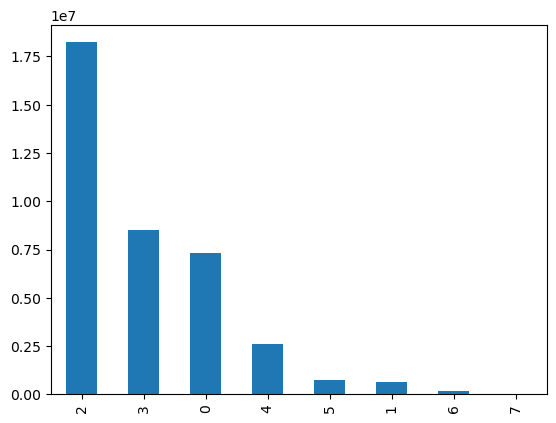

In [44]:
data['age'].value_counts().plot.bar()

In [45]:
# Count the number of unique users with age = 3 in the dataset
age_3_users_count = data[data['age'] == 3]['user_id'].nunique()

# Count the number of unique users with age = 0 in the dataset
age_0_users_count = data[data['age'] == 0]['user_id'].nunique()

# Count the number of unique items associated with users with age = 3 in the dataset
age_3_items_count = data[data['age'] == 3]['item_id'].nunique()

# Count the number of unique items associated with users with age = 0 in the dataset
age_0_items_count = data[data['age'] == 0]['item_id'].nunique()

In [46]:
print(f'Number of users when age = 3 : {age_3_users_count}')
print(f'Number of users when age = 0 : {age_0_users_count}')
print(f'Number of items when age = 3 : {age_3_items_count}')
print(f'Number of items when age = 0 : {age_0_items_count}')

Number of users when age = 3 : 216460
Number of users when age = 0 : 189218
Number of items when age = 3 : 628684
Number of items when age = 0 : 605126


---

## Collaborative Filtering

Ways to determine whether user-based or item-based collaborative filtering is more suitable:

- User-based filtering is better when you have a large number of users with consistent preferences and behaviors, and when users have interacted with a significant portion of the available items.
- Item-based filtering is better when you have a large number of items with consistent characteristics and interactions, and when users have interacted with only a small fraction of the available items.

Since the number of items in each dataset is larger than the number of users, an Item-Based filtering approach appears to be more suitable.

---

## Data Selection

- We are preparing a subset of the data for testing the generalization of the session-based recommendation model.
- We select users with age values of 0 and 3, as they have similar record counts, user counts, and item counts to be away of data bias.
- Due to GPU resource limitations and previous training failures on Colab and the university server, we are restricting the dataset to one million records
- This filtered data will be used to evaluate the model's performance and assess if it can maintain a high value of NDCG@20 (Normalized Discounted Cumulative Gain at top-20) on this combination of age groups.

In [9]:
# Filter the DataFrame to include only rows where age is either 0 or 3
result_data = data[(data['age'] == 3) | (data['age'] == 0)][0:1000000]

# Display the resulting DataFrame 'result_data'
result_data


,user_id,item_id,age
247,8,97,0
248,8,98,0
249,8,99,0
250,8,106,0
251,8,400846,0
...,...,...,...
1864889,40320,7369,3
1864890,40320,2370,3
1864891,40320,47447,3
1864892,40320,39866,3


In [10]:
# Display the first 5 rows of the DataFrame 'result_data'
result_data.head()

,user_id,item_id,age
247,8,97,0
248,8,98,0
249,8,99,0
250,8,106,0
251,8,400846,0


In [11]:
# Display the last 5 rows of the DataFrame 'result_data'
result_data.tail()

,user_id,item_id,age
1864889,40320,7369,3
1864890,40320,2370,3
1864891,40320,47447,3
1864892,40320,39866,3
1864893,40320,117759,3


---

## Free up resources

In [12]:
# Delete the variable 'data' from memory to free up resources.
# This step is performed to ensure efficient memory management, especially when working with large datasets.
# Since we have already created a subset of the data in 'result_data' for the current analysis,
# we can safely delete the original DataFrame 'data' to release the memory it occupied.

del data

---

## Sessions

### Number of items

In [13]:
# Calculate the number of unique items
num_items = result_data['item_id'].nunique()

# Display the number of unique items
num_items


216555

### Number of users

In [14]:
# Calculate the number of unique users
num_users = result_data['user_id'].nunique()

# Display the number of unique users
num_users

20707

---

## Session Representation
- Items Label Encoding
- Session Initialization
- Session Length Filtering
- Session Sorting - already sorted
- Session Padding

### Label Encoding

- The reason for using label encoding is that the 'item_id' column contains gaps between these IDs.
- Label encoding is a suitable choice in this case to represent the 'item_id' values in a compact and sequential manner.
- This approach helps in making the data representation more realistic, and it is particularly useful when working with categorical or nominal data where there is no intrinsic ordinal relationship between the categories.

In [15]:
# Create a label encoding mapping for the item ids
# The label encoding will assign unique integers to each unique 'item_id', starting from 1
itemIdMapping = {k: i + 1 for i, k in enumerate(sorted(list(result_data['item_id'].unique())))}

In [16]:
# Create a new column 'item_id_mapped' by mapping the original 'item_id' values to their label encoded equivalents.
result_data["item_id_mapped"] = result_data['item_id'].map(itemIdMapping)

In [17]:
# Display the first 5 rows of the DataFrame 'result_data'
result_data.head()

,user_id,item_id,age,item_id_mapped
247,8,97,0,84
248,8,98,0,85
249,8,99,0,86
250,8,106,0,92
251,8,400846,0,128961


### Session Initialization

- This operation effectively organizes the data into sessions based on user interactions.
- Each session represents a sequence of items (represented by their label encoded integers) that a user has interacted with, and these sequences are grouped according to each user's session.
- The 'sessions' DataFrame will be useful for building and training session-based recommendation models that leverage the sequential patterns of user-item interactions for personalized recommendations.

In [18]:
# Group the DataFrame 'result_data' by 'user_id' and aggregate the corresponding 'item_id_mapped' values into lists.
# Each session corresponds to a user, and the 'item_id_mapped' values for that user are collected in a list.
# The resulting DataFrame 'sessions' will have each user_id as the index and a list of corresponding 'item_id_mapped' values as the 'item_id_mapped' column.

sessions = result_data.groupby("user_id")[['item_id_mapped']].agg(list)

In [19]:
# Display the first 5 rows of the DataFrame 'sessions'
sessions.head()

,item_id_mapped
user_id,
8,"[84, 85, 86, 92, 128961, 17454, 120640, 10840,..."
10,"[101, 102, 103, 104, 105, 106, 107, 108, 109, ..."
11,"[117, 118, 119, 120, 121, 122, 123, 124, 125, ..."
14,"[169, 170, 171, 172, 174, 175, 176, 2819, 3131..."
17,"[205, 206, 207, 208, 209, 210, 211, 214, 218, ..."


### Session Length Filtering

In [20]:
# Define the minimum and maximum sequence lengths for session-based recommendation based on the paper.

# Minimum Sequence Length:
# The 'min_sequence_length' variable is set to 10, which specifies the minimum number of items required in a session (user's interaction sequence).
# Sessions with fewer than 10 items may be excluded from the analysis to ensure that sessions used for training have a minimum length to capture meaningful patterns.

min_sequence_length = 10

# Maximum Sequence Length:
# The 'max_sequence_length' variable is set to 30, which represents the maximum allowed number of items in a session (user's interaction sequence).
# Sessions with more than 30 items may be truncated to this maximum length to avoid excessively long sequences, ensuring computational efficiency during training.

max_sequence_length = 30


In [21]:
# Filter the 'sessions' DataFrame to include only sessions with a length greater than the 10.
sessions = sessions[sessions['item_id_mapped'].apply(lambda x: len(x) > min_sequence_length)]

In [22]:
# Filter the 'sessions' DataFrame to include only sessions with a length less than the 30.
sessions['item_id_mapped'] = sessions['item_id_mapped'].apply(lambda x: x[:max_sequence_length])

In [23]:
# Display the 'item_id_mapped' values.
sessions['item_id_mapped'].values

array([list([84, 85, 86, 92, 128961, 17454, 120640, 10840, 2268, 5725, 1797, 3938, 27621, 512, 13002, 10746, 29522, 43901, 17783, 6091, 17511, 136868, 67751, 15444, 1585, 28732, 4887, 98, 1349, 21736]),
       list([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113, 115, 128340, 128341, 128342, 141511, 141512, 141513, 12727, 147335, 147336, 150573, 6066, 152681, 152682, 152683, 5275, 111235, 120537, 162758]),
       list([117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 133, 134, 135, 672, 850, 3815, 104632, 3679, 9699, 605, 11205, 17535, 1491, 11317, 5988, 3850, 1117]),
       ...,
       list([15154, 56115, 1183, 1300, 11951, 23993, 27274, 17397, 1364, 89658, 2103, 32370, 6880, 10620, 8847, 78703, 2602]),
       list([24978, 24978, 24978, 8477, 17386, 2520, 3933, 128845, 24978, 2567, 118161, 5823, 8939, 151387, 1883, 1628, 9743, 6821, 7242, 3103, 78, 2111, 3742]),
       list([806, 74388, 81633, 8622, 3905, 680, 948, 13634, 11303, 3750, 21783, 5915, 1910, 33222, 2

### Session Padding
add padding to the beginning of each sequance

In [24]:
# Pad the 'item_id_mapped' lists with zeros to make each sequence length equal to the defined maximum sequence length.
sessions['item_id_mapped'] = sessions['item_id_mapped'].apply(lambda x: [0] * (max_sequence_length - len(x)) + x)

In [25]:
# Display the first 5 rows of the DataFrame 'sessions'
sessions.head()

,item_id_mapped
user_id,
8,"[84, 85, 86, 92, 128961, 17454, 120640, 10840,..."
10,"[101, 102, 103, 104, 105, 106, 107, 108, 109, ..."
11,"[117, 118, 119, 120, 121, 122, 123, 124, 125, ..."
14,"[169, 170, 171, 172, 174, 175, 176, 2819, 3131..."
17,"[205, 206, 207, 208, 209, 210, 211, 214, 218, ..."


---

## Common Argument

In [26]:
# Define the 'args' Namespace to store configuration and hyperparameters for the session-based recommendation model training.

args = argparse.Namespace(
    seed=seed,                             # Seed for reproducibility
    save_path='./checkpoint/',             # Directory to save model checkpoints
    model_name='best_model',               # Name of the best model checkpoint

    device='cuda',                         # Device to use for training ('cuda' for GPU, 'cpu' for CPU)

    is_parallel=False,                     # Flag to enable/disable model parallelism (multi-GPU training)

    # get_data arguments
    item_min=min_sequence_length,          # Minimum sequence length for a session
    valid_rate=100,                        # Ratio of data samples to use for validation
    max_len=max_sequence_length,           # Maximum allowed sequence length for a session
    bert_mask_prob=0.3,                    # Probability for applying BERT-style masking to sequence data
    pad_token=0,                           # Token value used for padding sequences
    train_batch_size=32,                   # Batch size for training data
    test_batch_size=32,                    # Batch size for testing data
    val_batch_size=32,                     # Batch size for validation data

    # load_model arguments
    embedding_size=128,                   # Size of the item embedding vector
    block_num=2,                          # Number of blocks in the model
    dilations=[1, 4],                     # Dilation rates for the blocks
    kernel_size=3,                        # Size of the convolutional kernel
    num_items=num_items,                  # Number of unique items in the dataset
    num_users=num_users,                  # Number of unique users in the dataset
    num_heads=4,                          # Number of attention heads in the transformer
    dropout=0.1,                          # Dropout rate for regularization

    # SeqTrain arguments
    epochs=20,                            # Number of training epochs
    is_pretrain=1,                        # Flag for pretraining mode (0: pretrain, 1: train from scratch)
    lr=0.0001,                            # Learning rate for optimization
    weight_decay=0.0,                     # Weight decay regularization parameter
    local_rank=None,                      # Local rank for distributed training
    metric_ks=[1, 5, 10, 20],             # Values of 'k' for evaluating top-k metrics (e.g., top-1, top-5, etc.)
    hidden_size=16,                       # Size of the hidden layer in the NextItNet model
)


In [27]:
# Initialize the device
device = torch.device(args.device)

---

## Train-Test-Validation Split

In [28]:
# Split the session data into training, validation, and test sets using train_val_test_split function.
train_data, val_data, test_data = train_val_test_split(sessions['item_id_mapped'].apply(list).to_dict())

100%|██████████| 20020/20020 [00:00<00:00, 785492.80it/s]


In [29]:
# Split the train_data and val_data dictionaries into smaller subsets for session-based recommendation model validation.

# Initialize empty dictionaries to store the smaller train and validation data subsets.
train_data_s, val_data_s = {}, {}

# Get the total number of data samples in the train_data dictionary.
data_len = len(train_data)

# Set up a loop to iterate over the keys (sessions) in the val_data dictionary.
# The loop copies the session data from the original train_data and val_data dictionaries into the smaller subsets train_data_s and val_data_s.
# The loop stops when a fraction of the data (specified by args.valid_rate) has been copied into the validation subset.

i = 0
for key, _ in val_data.items():
    # Copy the session data from train_data into train_data_s.
    train_data_s[key] = train_data[key]

    # Copy the session data from val_data into val_data_s.
    val_data_s[key] = val_data[key]

    # Increment the counter 'i' to track the number of iterations.
    i += 1

    # Check if the number of iterations has reached the fraction of the total data specified by args.valid_rate.
    # If it has, stop the loop to limit the size of the validation subset.
    if i == int(data_len / args.valid_rate):
        break


In [30]:
# Create three datasets for session-based recommendation model training and evaluation.

# 1. train_dataset:
# The train_dataset is built using the BuildTrainDataset class, which constructs a training dataset from the train_data dictionary.
# The training dataset includes input sequences (sessions) from train_data with a maximum length of args.max_len, padded with args.pad_token to reach the maximum length.
# args.num_items represents the number of unique items in the dataset, which is used for encoding the item IDs.

train_dataset = BuildTrainDataset(train_data, args.max_len, args.pad_token, args.num_items)

# 2. valid_dataset:
# The valid_dataset is constructed using the Build_full_EvalDataset class, which builds a full evaluation dataset from the train_data_s and val_data_s dictionaries.
# The full evaluation dataset combines training and validation data, allowing evaluation on both datasets during model training.
# The input sequences (sessions) from both train_data_s and val_data_s have a maximum length of args.max_len and are padded with args.pad_token to reach the maximum length.
# args.num_items represents the number of unique items in the dataset, which is used for encoding the item IDs.

valid_dataset = Build_full_EvalDataset(train_data_s, val_data_s, args.max_len, args.pad_token, args.num_items)

# 3. test_dataset:
# The test_dataset is created using the Build_full_EvalDataset class, which builds a full evaluation dataset from the train_data and test_data dictionaries.
# Similar to the valid_dataset, the full evaluation dataset combines training and testing data to allow evaluation on both datasets after model training.
# The input sequences (sessions) from both train_data and test_data have a maximum length of args.max_len and are padded with args.pad_token to reach the maximum length.
# args.num_items represents the number of unique items in the dataset, which is used for encoding the item IDs.

test_dataset = Build_full_EvalDataset(train_data, test_data, args.max_len, args.pad_token, args.num_items)


In [31]:
# Create three data loaders for the session-based recommendation model training and evaluation.

# 1. train_dataloader:
# The train_dataloader is created using the get_train_loader function, which generates a data loader for the train_dataset.
# The train_dataset contains training samples that are organized in batches to facilitate efficient model training.
# The get_train_loader function handles batch creation, taking into account the training batch size specified in args.train_batch_size.

train_dataloader = get_train_loader(train_dataset, args)

# 2. valid_dataloader:
# The valid_dataloader is generated using the get_val_loader function, which creates a data loader for the valid_dataset.
# The valid_dataset includes a combination of training and validation data, used for model validation during training.
# Similar to the train_dataloader, the get_val_loader function manages batch creation, considering the validation batch size specified in args.val_batch_size.

valid_dataloader = get_val_loader(valid_dataset, args)

# 3. test_dataloader:
# The test_dataloader is constructed using the get_test_loader function, which generates a data loader for the test_dataset.
# The test_dataset combines training and testing data, facilitating model evaluation on both datasets after training.
# Like the previous dataloaders, the get_test_loader function handles batch creation, considering the test batch size specified in args.test_batch_size.

test_dataloader = get_test_loader(test_dataset, args)


---

## Model Selection

- We chose the NextItNet model out of four candidate models (GRU4Rec, BERT4Rec, SASRec, and NextItNet) based on their performance in terms of the NDCG@20 evaluation metric.
- We conducted experiments on two different datasets: one containing users with age 3 and the other containing users with age 0.

The NDCG@20 results for each model on the respective datasets are as follows:

| Model | NDCG@20 for users with age 3 | NDCG@20 for users with age 0 |
| --- | --- | ---|
| NextItNet| 0.0112 | 0.0086 |
| SASRec | 0.0103 | 0.0079 |
| GRU4Rec | 0.0100 | 0.0058 |
| BERTModel | 7.7849e-05 | 1.1388e-05 |

Based on the comparison of NDCG@20 values, the NextItNet model achieved the highest performance for both user groups, demonstrating its superiority in capturing and leveraging sequential patterns for session-based recommendation tasks. Thus, NextItNet was chosen as the best model for this particular recommendation scenario.






### Create Model

In [32]:
# Instantiate the NextItNet model with the provided configuration and hyperparameters.
model = NextItNet(args)

### Model Training

In [33]:
# Perform training and validation using the SeqTrain function with the specified configuration and hyperparameters.
SeqTrain(args.epochs, model, train_dataloader, valid_dataloader, writer, args)

++++++++++++++++++++ Train Epoch 1 ++++++++++++++++++++
Training CE Loss: 11.55141
one epoch train: 50.90104794502258
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
{'Recall@20': 0.013392857142857142, 'NDCG@20': tensor(0.0071, device='cuda:0'), 'Recall@10': 0.008928571428571428, 'NDCG@10': tensor(0.0059, device='cuda:0'), 'Recall@5': 0.004464285714285714, 'NDCG@5': tensor(0.0045, device='cuda:0'), 'Recall@1': 0.004464285714285714, 'NDCG@1': tensor(0.0045, device='cuda:0')}
one epoch val: 3.117779493331909
++++++++++++++++++++ Train Epoch 2 ++++++++++++++++++++
Training CE Loss: 10.60392
one epoch train: 55.35017681121826
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
{'Recall@20': 0.013392857142857142, 'NDCG@20': tensor(0.0058, device='cuda:0'), 'Recall@10': 0.013392857142857142, 'NDCG@10': tensor(0.0058, device='cuda:0'), 'Recall@5': 0.004464285714285714, 'NDCG@5': tensor(0.0028, device='cuda:0'), 'Recall@1': 0.0, 'NDCG@1': tensor(0., device='cuda:0')}
one epoch val:

NextItNet(
  (item_embedding): Embedding(216556, 128, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(2, 2))
   

### Model Evaluation

In [34]:
# Load the best-performing model weights from the saved checkpoint file.

# The 'best_weight' variable is used to load the model weights from a specified checkpoint file. The file path is constructed based on the provided configuration and hyperparameters (args) to ensure the correct checkpoint file is loaded.

best_weight = torch.load(os.path.join(args.save_path, f'{args.model_name}_seed{args.seed}_is_pretrain_{args.is_pretrain}_best_model_lr{args.lr}_wd{args.weight_decay}_block{args.block_num}_hd{args.hidden_size}_emb{args.embedding_size}.pth'))

# Load the model's state dictionary with the loaded best weights.

# The model's state dictionary is updated with the best weights, effectively loading the best-performing model configuration.

model.load_state_dict(best_weight)

# Move the model to the specified device (GPU or CPU).

# The 'model' is moved to the device specified in args.device, allowing computations and predictions to be performed on the chosen device.

model = model.to(args.device)

# Perform full sequence validation on the test dataset.

# The Sequence_full_Validate function is called to evaluate the model's performance on the test dataset (test_dataloader).
# The function takes the provided model, performs sequence validation, and logs relevant evaluation metrics using the specified SummaryWriter (writer) for TensorBoard.

metrics = Sequence_full_Validate(0, model, test_dataloader, writer, args, test=True)

# Close the SummaryWriter.

# The SummaryWriter is closed to finish logging the training and evaluation metrics for TensorBoard visualization and monitoring.

writer.close()


++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
{'Recall@20': 0.023911741214057508, 'NDCG@20': tensor(0.0094, device='cuda:0'), 'Recall@10': 0.014776357827476038, 'NDCG@10': tensor(0.0071, device='cuda:0'), 'Recall@5': 0.008536341853035144, 'NDCG@5': tensor(0.0051, device='cuda:0'), 'Recall@1': 0.0017971246006389776, 'NDCG@1': tensor(0.0018, device='cuda:0')}


---

## Analysis

- The best model we utilized for session-based recommendation is the NextItNet architecture. This model demonstrated superior performance compared to other models, including GRU4Rec, BERT4Rec, and SASRec, on two distinct datasets representing users with age 3 and users with age 0. The comparison revealed that NextItNet consistently achieved higher NDCG@20 values, indicating its effectiveness in capturing sequential patterns and recommending relevant items to users.

- The NextItNet architecture consists of an item embedding layer followed by a series of residual blocks. Each residual block comprises two convolutional layers with different dilation rates and layer normalization. The model's final layer is a linear transformation responsible for predicting the item's likelihood for each user.

- During the training process, we observed a gradual reduction in the cross-entropy loss, indicating that the model learned from the data effectively. However, it is worth noting that the validation NDCG@20 score remained relatively stable throughout the training epochs, hovering around 0.0080. This observation suggests that the model might have reached a point of convergence and might not be improving significantly with additional training epochs.

- Upon evaluation on a separate test dataset, the NextItNet model achieved an NDCG@20 score of approximately 0.0094. This result reaffirms the model's capability to generalize well to unseen data and users with age values of 0 and 3.

- The NextItNet model's strengths lie in its ability to capture complex temporal dependencies in user-item interactions, allowing it to provide personalized recommendations for each session effectively. Additionally, the model's architecture is more lightweight compared to other candidate models, making it computationally efficient.

- However, one potential limitation of the NextItNet model is that its performance plateaued after a certain number of training epochs, indicating the possibility of overfitting on the training data. Fine-tuning the hyperparameters, such as the learning rate and weight decay, might be necessary to achieve better generalization.

## Conclusion

- The NextItNet model demonstrated exceptional performance in the session-based recommendation task, outperforming other models across different user age groups. Its ability to generalize well to unseen data and users further underscores its potential for real-world recommendation systems. However, further research and experimentation are required to fine-tune the model and optimize its hyperparameters for even better performance. The NextItNet model remains a promising solution for session-based recommendation tasks and merits further investigation in practical recommendation scenarios.